## NLP Lab Exercise 3
### Agustinus Kristiadi

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data Exploration

In [3]:
df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

In [4]:
df.shape

(10240, 14)

In [5]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


### Extracting the training data

In [6]:
y_train = df[1]
y_train.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [7]:
X_train = df[2]
X_train.head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: 2, dtype: object

Load test set:

In [8]:
df_test = pd.read_csv('liar_dataset/test.tsv', sep='\t', header=None)
X_test = df_test[2]
y_test = df_test[1]

### Feature extraction

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Scenario 1: True vs Rest

First we need to replace all labels that are not 'true' to a single class 'false':

In [11]:
y_train_1 = y_train.copy()
y_train_1[y_train != 'true'] = 'false'

print('Num true: {}'.format((y_train_1 == 'true').sum()))
print('Num false: {}'.format((y_train_1 == 'false').sum()))

y_test_1 = y_test.copy()
y_test_1[y_test != 'true'] = 'false'

Num true: 1676
Num false: 8564


Notice that the resulting labels are imbalanced.

In [12]:
clf = LogisticRegression(class_weight='balanced') 

accuracy:   0.685
Confusion matrix, without normalization


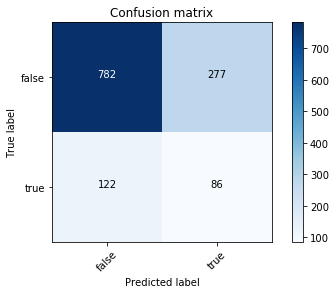

In [13]:
clf.fit(tfidf_train, y_train_1)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test_1, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test_1, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

The resulting predictions are biased, due to the training data imbalance.

### Scenario 2: (True + Mostly True + Half True) vs Rest

Replace ('true', 'mostly-true', 'half-true') with single label 'true'. Also replace the rest of the labels with 'false'.

In [14]:
positives = ['true', 'mostly-true', 'half-true']

# Train
y_train_2 = y_train.copy()

for pos in positives:
    y_train_2[y_train == pos] = 'true'
y_train_2[y_train_2 != 'true'] = 'false'
    
print('Num true: {}'.format((y_train_2 == 'true').sum()))
print('Num false: {}'.format((y_train_2 == 'false').sum()))

# Test
y_test_2 = y_test.copy()

for pos in positives:
    y_test_2[y_test == pos] = 'true'
y_test_2[y_test_2 != 'true'] = 'false'

Num true: 5752
Num false: 4488


The resulting training data are more or less balanced.

In [15]:
clf = LogisticRegression(class_weight='balanced') 
clf.fit(tfidf_train, y_train_2)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test_2, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.601


Confusion matrix, without normalization


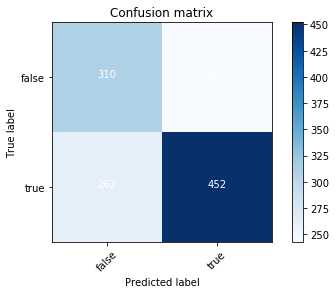

In [16]:
cm = metrics.confusion_matrix(y_test_2, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])